
- Defina caminhos de abordagem para o problema
- Apresente e justifique a escolha de 3 zip codes para a expansão da rede
- Utilize as bases de dados disponibilizadas
- Apresente os resultados usando uma apresentação clara e objetiva

Bem vou registrar aqui meu pensamento ao abordar esse problema.
Oque temos que fazer aqui é analisar qual a segmentação do público do laboratório.
Isto é, qual a idade, sexo, renda média dos clientes e quanto eles costumam gastar
Uma vez que descobrirmos esses dados do público procurar bairros/cidades semelhantes que ainda não tem o lab
E ai escolher quais as melhores opções

Primeiramente vou importar as tabelas e dar uma olhada nelas

In [1]:
# Aqui será feita a importação de todas as bibliotecas utilizadas no código

import pandas as pd
from unidecode import unidecode
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.api as sm
from geopy.geocoders import Nominatim




C:\Users\rafae\AppData\Local\Temp\ipykernel_38588\1118371638.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Importando os arquivos csv e transformando eles em Data Frames

df_demo = pd.read_csv('DemographicData_ZCTAs.csv');
df_geocode = pd.read_csv('df_geocode.csv');
df_economic = pd.read_csv('EconomicData_ZCTAs.csv');
df_test_data = pd.read_csv('test_data.csv');
df_transactional_data = pd.read_csv('transactional_data.csv', delimiter=';');

In [3]:
# Procurar se algum desses DFs apresenta dados duplicados

print(df_demo.duplicated().value_counts())
print(df_geocode.duplicated().value_counts())
print(df_economic.duplicated().value_counts())
print(df_test_data.duplicated().value_counts())
print(df_transactional_data.duplicated().value_counts())

False    33120
Name: count, dtype: int64
False    119
Name: count, dtype: int64
False    629280
Name: count, dtype: int64
False    2002
Name: count, dtype: int64
False    2340722
True       14519
Name: count, dtype: int64


In [4]:
# Removendo as linhas duplicadas em df_transactional_data

df_transactional_data = df_transactional_data.drop_duplicates()
print(df_transactional_data.duplicated().value_counts())

False    2340722
Name: count, dtype: int64


Após dar uma olhada nesses Data Frames acredito que preciso de usar os dados em "transactional"
para descobrir a segmentação do público que costuma utilizar o laboratório

Minha hipótese inicial era utilizar "transactional" e "test_data"
Mas eu fico pensando se de fato saber quais os testes que cada paciente está realizando vai
agregar à análise, talvez seja melhor somar todos os gastos realizados em cada visita do cliente
Então no DF "transactional" ao invés de ter 10 entradas descrevendo cada teste feito em uma única visita
do cliente, vou ter o valor total gasto em uma visita.
De qualquer forma eu sei que eu quero transformar a info data de nascimento em idade




In [5]:
# Após minhas primeiras interações com o código, percebi que:
# o nome das colunas precisava de tratamento, porque havia espaços nos nomes e haviam letras maiusculas e minusculas misturadas
# Criei uma função para colocar o código em snake case, isto é, tudo em minúsculo e as palavras separadas por "_"

def transformar_nomes_colunas(df):
    novos_nomes_colunas = {coluna: unidecode(coluna).replace(" ", "_").lower() for coluna in df.columns}
    df.rename(columns=novos_nomes_colunas, inplace=True)

transformar_nomes_colunas(df_demo)
transformar_nomes_colunas(df_geocode)
transformar_nomes_colunas(df_economic)
transformar_nomes_colunas(df_test_data)
transformar_nomes_colunas(df_transactional_data)

In [6]:
# Agora vou checar se o tipo das variáveis está correto


print(df_transactional_data.dtypes)

patient_id         object
gender             object
date_of_birth      object
date_of_service    object
service_id         object
lab_id             object
coditem             int64
testing_cost       object
dtype: object


In [7]:
# Vou checar se alguma linha apresenta dados nulos

linhas_com_nulos = df_transactional_data.isna().any(axis=1)


print(df_transactional_data[linhas_com_nulos])

           patient_id gender date_of_birth date_of_service      service_id  \
1253947  7659985004-1      F           NaN      2020-02-22  7659985004-2-1   

        lab_id   coditem testing_cost  
1253947   L152  70000107         48,0  


In [8]:
# Removendo essa linha

df_transactional_data = df_transactional_data.drop(index=1253947)

In [9]:
df_transactional_data['patient_id'] = df_transactional_data['patient_id'].astype(str)
df_transactional_data['gender'] = df_transactional_data['gender'].astype(str)
df_transactional_data['date_of_birth'] = pd.to_datetime(df_transactional_data['date_of_birth'], format="%d/%m/%Y %H:%M:%S")
df_transactional_data['date_of_birth'] = df_transactional_data['date_of_birth'].dt.date
df_transactional_data['date_of_birth'] = pd.to_datetime(df_transactional_data['date_of_birth'], format="%Y-%m-%d")
df_transactional_data['date_of_service'] = pd.to_datetime(df_transactional_data['date_of_service'], format="%Y-%m-%d")
df_transactional_data['service_id'] = df_transactional_data['service_id'].astype(str)
df_transactional_data['lab_id'] = df_transactional_data['lab_id'].astype(str)
df_transactional_data['coditem'] = df_transactional_data['coditem'].astype(str)
df_test_data['coditem'] = df_test_data['coditem'].astype(str)
df_transactional_data['testing_cost'] = df_transactional_data['testing_cost'].str.replace(',', '.').astype(float)
df_transactional_data['testing_cost'] = df_transactional_data['testing_cost'].astype(float)

In [10]:
print(df_transactional_data.dtypes)

patient_id                 object
gender                     object
date_of_birth      datetime64[ns]
date_of_service    datetime64[ns]
service_id                 object
lab_id                     object
coditem                    object
testing_cost              float64
dtype: object


In [11]:
df_transactional_data.head()

,patient_id,gender,date_of_birth,date_of_service,service_id,lab_id,coditem,testing_cost
0,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70003237,9.0
1,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000638,13.0
2,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001597,49.0
3,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000103,11.0
4,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000224,10.0


In [12]:
df_transactional_data['age'] = (df_transactional_data['date_of_service'] - df_transactional_data['date_of_birth']).dt.days // 365
df_transactional_data['age'] = df_transactional_data['age'].astype(int)
df_transactional_data.head(15)


,patient_id,gender,date_of_birth,date_of_service,service_id,lab_id,coditem,testing_cost,age
0,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70003237,9.0,42
1,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000638,13.0,42
2,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001597,49.0,42
3,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000103,11.0,42
4,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000224,10.0,42
5,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70002653,8.0,42
6,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001206,41.0,42
7,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70005903,57.0,42
8,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000392,8.0,42
9,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000168,48.0,42


In [13]:
# Vou verificar como estão os valores para oa tributo "gender"

df_transactional_data["gender"].value_counts()

gender
F    1491029
M     849683
I          9
Name: count, dtype: int64

In [14]:
# Muito interessante ver que mulheres procuram bem mais os serviços do laboratório
# Vou remover as linhas cujo o valor é I

df_transactional_data = df_transactional_data[df_transactional_data["gender"] != "I"]


In [15]:
# Agora vou verificar se existem inconsistências com a idade

df_transactional_data["age"].describe()

count    2.340712e+06
mean     4.149545e+01
std      1.747037e+01
min      0.000000e+00
25%      3.000000e+01
50%      4.200000e+01
75%      5.400000e+01
max      1.590000e+02
Name: age, dtype: float64

In [16]:
# Chamou a atenção que a idade máxima é 159, quero dar uma olhada nas entradas que a idade é superior a 100 anos

print(df_transactional_data[df_transactional_data["age"] >= 100])

                  patient_id gender date_of_birth date_of_service  \
10476     10240389069-BIO010      F    1916-12-02      2019-02-07   
26938     10240407527-BIO010      F    1914-03-31      2019-03-08   
43133     10240411467-BIO010      F    1916-04-30      2019-03-16   
50045    531400001029-BIO010      F    1917-11-26      2019-03-12   
60446     10240399832-BIO010      F    1918-02-17      2019-02-23   
...                      ...    ...           ...             ...   
2328365         6002684910-1      F    1919-06-03      2021-01-30   
2328366         6002684910-1      F    1919-06-03      2021-01-30   
2328367         6002684910-1      F    1919-06-03      2021-01-30   
2328368         6002684910-1      F    1919-06-03      2021-01-30   
2328369         6002684910-1      F    1919-06-03      2021-01-30   

               service_id lab_id   coditem  testing_cost  age  
10476    531400149778-135   L075  70005506          55.0  102  
26938    529400115060-122   L668  70005506 

Após analisar a coluna "age" deu para perceber que existem algumas entradas com valores absurdos como 120 e 159 anos
Optei por remover as cerca de 450 entradas com valores acima ou iguais a 100 anos, por entender que provavelmente vários desses valores estão incorretos ou se tratam de outliers

In [17]:
df_transactional_data = df_transactional_data[df_transactional_data["age"] < 100]
df_transactional_data = df_transactional_data[df_transactional_data["age"] > 0]
df_transactional_data["age"].describe()

count    2.340223e+06
mean     4.148337e+01
std      1.745063e+01
min      1.000000e+00
25%      3.000000e+01
50%      4.200000e+01
75%      5.400000e+01
max      9.900000e+01
Name: age, dtype: float64

In [18]:
# Vou verificar agora os valores dos testes e comparar com os valores da tabela test_data

df_transactional_data["testing_cost"].describe()

count    2.340223e+06
mean     5.110670e+01
std      9.790694e+01
min      0.000000e+00
25%      1.100000e+01
50%      2.400000e+01
75%      4.900000e+01
max      9.500000e+03
Name: testing_cost, dtype: float64

In [19]:

df_test_data["testing_cost"].describe()

count    2002.000000
mean       77.767453
std       146.066382
min         0.000000
25%         4.812500
50%        21.190000
75%        79.270000
max      1762.460000
Name: testing_cost, dtype: float64

Encontrei 205 dados que estão mais caros que o teste mais caro, vou tentar analisar talvez a virgula esteja do lugar errado, mas qualquer coisa eu só deleto esses dados mesmo...

Depois de muitos testes eu percebi que apesar de terem o mesmo nome, a varivel "testing_cost" está medindo coisas diferentes em df_test_data e df_transactional_data

Em df_test_data está medido o custo de aplicação do teste

Em df_transactional_data está medido qual o valor cobrado do cliente

Com o valor de custo e o valor de venda é possivel calcular o valor de venda

Vou criar um novo df e calcular esses valores

In [20]:
df_transactional_data=df_transactional_data.rename(columns={'testing_cost':'testing_sale_price' })


In [21]:
df_transactional_data.head()

,patient_id,gender,date_of_birth,date_of_service,service_id,lab_id,coditem,testing_sale_price,age
0,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70003237,9.0,42
1,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000638,13.0,42
2,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001597,49.0,42
3,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000103,11.0,42
4,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000224,10.0,42


In [22]:
df_transactional_silver = df_transactional_data

In [23]:
df_transactional_silver = pd.merge(df_transactional_silver, df_test_data[['coditem', 'testing_cost']], on='coditem')

In [24]:
df_transactional_silver.head(30)

,patient_id,gender,date_of_birth,date_of_service,service_id,lab_id,coditem,testing_sale_price,age,testing_cost
0,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70003237,9.0,42,1.78
1,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000638,13.0,42,2.46
2,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001597,49.0,42,2.11
3,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000103,11.0,42,0.80
4,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000224,10.0,42,1.02
5,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70002653,8.0,42,1.29
6,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001206,41.0,42,2.20
7,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70005903,57.0,42,2.20
8,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000392,8.0,42,1.43
9,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000168,48.0,42,2.38


In [25]:
df_transactional_silver['profit'] = (df_transactional_silver['testing_sale_price'] - df_transactional_silver['testing_cost'])


In [26]:
df_transactional_silver.describe()

,date_of_birth,date_of_service,testing_sale_price,age,testing_cost,profit
count,2339986,2339986,2.339986e+06,2.339986e+06,2.339986e+06,2.339986e+06
mean,1978-01-29 03:52:06.175626624,2020-01-12 13:26:13.766338816,5.110775e+01,4.148366e+01,1.559880e+01,3.550896e+01
min,1919-05-28 00:00:00,2019-01-01 00:00:00,0.000000e+00,1.000000e+00,0.000000e+00,-1.291210e+03
25%,1965-04-08 00:00:00,2019-07-11 00:00:00,1.100000e+01,3.000000e+01,1.230000e+00,8.790000e+00
50%,1977-08-12 00:00:00,2020-01-15 00:00:00,2.400000e+01,4.200000e+01,2.390000e+00,1.455000e+01
75%,1989-08-07 00:00:00,2020-07-13 00:00:00,4.900000e+01,5.400000e+01,4.970000e+00,3.732000e+01
max,2020-02-08 00:00:00,2021-02-12 00:00:00,9.500000e+03,9.900000e+01,1.762460e+03,8.009230e+03
std,NaN,NaN,9.785984e+01,1.745031e+01,4.186369e+01,7.093364e+01


Alguns testes estão dando prejuizo, tenho que verificar se essa infromação esta correta

In [27]:
df_prejuizo = df_transactional_silver.loc[df_transactional_silver['profit'] < 0, ['coditem', 'profit', 'testing_sale_price', 'testing_cost']]
df_prejuizo = df_prejuizo.drop_duplicates(subset=['coditem'])

Antes eu havia colocado <= 0
Mas verifiquei que esses casos eram testes derivados de outros, e tinham custo e cobrança 0

In [28]:
min_profit_index = df_prejuizo['profit'].idxmin()
row_with_min_profit = df_prejuizo.loc[min_profit_index]
print(row_with_min_profit)

coditem               70004827
profit                -1291.21
testing_sale_price        29.0
testing_cost           1320.21
Name: 39710, dtype: object


In [29]:
df_transactional_silver = df_transactional_silver[df_transactional_silver["profit"] > -10]

In [30]:
min_profit_index = df_transactional_silver['profit'].idxmin()
row_with_min_profit = df_transactional_silver.loc[min_profit_index]
print(row_with_min_profit)

patient_id             10210867497-BIO003
gender                                  F
date_of_birth         1967-12-22 00:00:00
date_of_service       2019-02-23 00:00:00
service_id                575007183469-72
lab_id                               L155
coditem                          70005280
testing_sale_price                  290.0
age                                    51
testing_cost                       299.76
profit                              -9.76
Name: 10786, dtype: object


Optei por remover todos os valores em que o prejuizo fosse maior que 10
Pelo oque observei os maiores valores de prejuizo eram de testes que tinham poucas entradas, levando a acreditar que é provavel que havia um erro
Mas quando chega em prejuizos de -10 aumenta consideravelmente a contagem de testes feitos
Pensei em descartar todas as entradas com prejuizo,
Mas depois pensei que esses testes podem estar sendo feitos em conjunto com outros 


In [31]:
df_transactional_silver.to_csv('df_transactional_silver.csv', index=False)

In [32]:
df_transactional_silver.describe()

,date_of_birth,date_of_service,testing_sale_price,age,testing_cost,profit
count,2305650,2305650,2.305650e+06,2.305650e+06,2.305650e+06,2.305650e+06
mean,1978-01-28 12:28:11.501138560,2020-01-12 12:44:14.598918144,5.088767e+01,4.148524e+01,1.430311e+01,3.658456e+01
min,1919-05-28 00:00:00,2019-01-01 00:00:00,0.000000e+00,1.000000e+00,0.000000e+00,-9.760000e+00
25%,1965-04-10 00:00:00,2019-07-11 00:00:00,1.000000e+01,3.000000e+01,1.230000e+00,8.790000e+00
50%,1977-08-10 00:00:00,2020-01-15 00:00:00,2.300000e+01,4.200000e+01,2.390000e+00,1.498000e+01
75%,1989-08-02 00:00:00,2020-07-12 00:00:00,4.900000e+01,5.400000e+01,4.390000e+00,3.760000e+01
max,2020-02-08 00:00:00,2021-02-12 00:00:00,9.500000e+03,9.900000e+01,1.762460e+03,8.009230e+03
std,NaN,NaN,9.770138e+01,1.745075e+01,3.858785e+01,7.082969e+01


Vou descobrir quais as unidades mais lucrativas e vou tentar fazer um "look alike"
Ou seja, procurar regiões que possuem um perfil economico e demográfico semelhante


In [33]:
lab_profit_sum = df_transactional_silver.groupby('lab_id')['profit'].sum()

sorted_lab_profit_sum = lab_profit_sum.sort_values(ascending=False)

sorted_lab_profit_sum.head(20)

lab_id
L133    6314955.82
L139    5256791.38
L121    4337530.00
L123    4192069.97
L152    3836704.74
L166    3712630.76
L155    3578885.36
L156    3320743.77
L662    2298005.53
L061    2201796.66
L157    1953306.83
L150    1884964.02
L664    1768469.56
L141    1739404.19
L126    1374973.35
L158    1292782.86
L131    1237642.23
L132    1166957.83
L120    1106662.86
L148    1078836.20
Name: profit, dtype: float64

Vou tratar o df_geocode antes de puxar para outra tabela

In [34]:
df_geocode

,unnamed:_0,lab_id,address,location,zipcode
0,0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0
1,1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0
2,2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0
3,3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0
4,4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0
...,...,...,...,...,...
114,114,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002.0
115,115,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421.0
116,116,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304.0
117,117,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806.0


In [35]:
# Removendo duplicadas

print(df_geocode.isna().sum().sum())
df_geocode = df_geocode.dropna()


1


In [36]:
df_geocode

,unnamed:_0,lab_id,address,location,zipcode
0,0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0
1,1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0
2,2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0
3,3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0
4,4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0
...,...,...,...,...,...
114,114,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002.0
115,115,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421.0
116,116,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304.0
117,117,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806.0


In [37]:
df_geocode = df_geocode.drop(columns=['unnamed:_0'])


In [39]:

# Configurar opções para exibir DataFrame inteiro
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Exibir DataFrame inteiro
print(df_geocode)

# Restaurar opções padrão
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')


    lab_id                                            address  \
0     L152      3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096   
1     L520                    1614 N JAMES ST, ROME, NY 13440   
2     L141     12911 120TH AVE NE STE D60, KIRKLAND, WA 98034   
3     L524  5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342   
4     L545                 1204 IL HWY 164, OQUAWKA, IL 61469   
5     L158  3400 ARAMINGO AVE STE 4, PHILADELPHIA, PA 19134\n   
6     L172     1129 HOSPITAL DR STE 5E, STOCKBRIDGE, GA 30281   
7     L518         1763 SANTA RITA ROAD, PLEASANTON, CA 94566   
8     L531     5860 OWENS DR. SUITE 120, PLEASANTON, CA 94588   
9     L160                   135 BROADWAY, LAWRENCE, MA 01840   
10    L533  120 LA CASA VIA SUITE 102, WALNUT CREEK, CA 94598   
11    L537  5255 MARLTON PIKE RT 70 STE D, PENNSAUKEN, NJ ...   
12    L061      1135 116TH AVE NE STE 110, BELLEVUE, WA 98004   
13    L536         5511 CHAMBLEE DUNWOODY, DUNWOODY, GA 30338   
14    L153     790 CHURCH

In [40]:
#df_geocode = df_geocode.drop(83)

In [41]:
df_geocode.to_csv('df_geocode_tratar.csv', index=False)

In [42]:
df_geocode['zipcode'] = df_geocode['zipcode'].astype(int)
df_geocode['zipcode'] = df_geocode['zipcode'].astype(str)

df_geocode = df_geocode.rename(columns={'zipcode': 'zip_code'})
df_geocode = df_geocode.rename(columns={'zipcode': 'zip_code'})

In [43]:

def corrigir_address(row):
    if '\n' in row['address']:
       
        row['address'] = row['address'].replace('\n', '')
    return row

# Aplicar a função à coluna 'address'

df_geocode = df_geocode.apply(corrigir_address, axis=1)


df_geocode.loc[df_geocode['lab_id'] == 'L158', 'zip_code'] = '19134'
df_geocode.loc[df_geocode['lab_id'] == 'L664', 'zip_code'] = '02169'
df_geocode.loc[df_geocode['lab_id'] == 'L160', 'zip_code'] = '01840'
df_geocode.loc[df_geocode['lab_id'] == 'L537', 'zip_code'] = '08109'
df_geocode.loc[df_geocode['lab_id'] == 'L521', 'zip_code'] = '02359'
df_geocode.loc[df_geocode['lab_id'] == 'L069', 'zip_code'] = '01605'
df_geocode.loc[df_geocode['lab_id'] == 'L526', 'zip_code'] = '08108'
df_geocode.loc[df_geocode['lab_id'] == 'L529', 'zip_code'] = '02762'
df_geocode.loc[df_geocode['lab_id'] == 'L564', 'zip_code'] = '01844'
df_geocode.loc[df_geocode['lab_id'] == 'L144', 'zip_code'] = '03054'
df_geocode.loc[df_geocode['lab_id'] == 'L922', 'zip_code'] = '02190'
df_geocode.loc[df_geocode['lab_id'] == 'L523', 'zip_code'] = '19107'
df_geocode.loc[df_geocode['lab_id'] == 'L522', 'zip_code'] = '01702'
df_geocode.loc[df_geocode['lab_id'] == 'L517', 'zip_code'] = '01606'
df_geocode.loc[df_geocode['lab_id'] == 'L660', 'zip_code'] = '03087'
df_geocode.loc[df_geocode['lab_id'] == 'L697', 'zip_code'] = '01950'
df_geocode.loc[df_geocode['lab_id'] == 'L170', 'zip_code'] = '03079'
df_geocode.loc[df_geocode['lab_id'] == 'L082', 'zip_code'] = '03087'
df_geocode.loc[df_geocode['lab_id'] == 'L162', 'zip_code'] = '02019'
df_geocode.loc[df_geocode['lab_id'] == 'L173', 'zip_code'] = '01701'
df_geocode.loc[df_geocode['lab_id'] == 'L886', 'zip_code'] = '08002'



In [44]:
df_geocode.to_csv('df_geocode_tratar.csv', index=False)

In [45]:
import folium

df_geocode = pd.DataFrame(df_geocode)

# Convertendo as coordenadas para números
df_geocode[['latitude', 'longitude']] = df_geocode['location'].str.split(',', expand=True).astype(float)

# Criando um mapa centrado nas coordenadas médias
map_center = [df_geocode['latitude'].mean(), df_geocode['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=4)

# Adicionando marcadores ao mapa
for i, row in df_geocode.iterrows():
    location = (row['latitude'], row['longitude'])
    
    folium.Marker(
        location=location,
        popup=f"{row['lab_id']} - {row['address']}",
        icon=folium.Icon(color='red')
    ).add_to(mymap)

# Exibindo o mapa
mymap

Agora vou utilizar os dfs com os dados demograficos e o com dados economicos, mas aqui existe um problema,
o zip code precisar ser tratado


In [46]:
print(df_demo.dtypes)


unnamed:_0                           int64
id                                  object
geographicareaname                  object
totalpopulation                      int64
sexratio(males_per_100_females)    float64
population_under5years               int64
population_5to9years                 int64
population_10to14years               int64
population_15to19years               int64
population_20to24years               int64
population_25to34years               int64
population_35to44years               int64
population_45to54years               int64
population_55to59years               int64
population_60to64years               int64
population_65to74years               int64
population_75to84years               int64
population_85yearsandover            int64
medianageinyears                   float64
dtype: object


In [47]:
print(df_economic.dtypes)

unnamed:_0                             int64
id                                    object
geographic_area_name                  object
totalhouseholds_lessthan$10.000        int64
totalhouseholds_$10.000to$14.999       int64
totalhouseholds_$15.000to$24.999       int64
totalhouseholds_$25.000to$34.999       int64
totalhouseholds_$35.000to$49.999       int64
totalhouseholds_$50.000to$74.999       int64
totalhouseholds_$75.000to$99.999       int64
totalhouseholds_$100.000to$149.999     int64
totalhouseholds_$150.000to$199.999     int64
totalhouseholds_$200.000ormore         int64
dtype: object


In [48]:

df_demo_split = df_demo['geographicareaname'].str.split(' ', expand=True)

df_demo['zip_code'] = df_demo_split[1]

df_demo.head()


,unnamed:_0,id,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_15to19years,population_20to24years,population_25to34years,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears,zip_code
0,0,8600000US35004,ZCTA5 35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5,35004
1,1,8600000US35005,ZCTA5 35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0,35005
2,2,8600000US35006,ZCTA5 35006,2883,108.2,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2,35006
3,3,8600000US35007,ZCTA5 35007,26332,95.0,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7,35007
4,4,8600000US35010,ZCTA5 35010,20613,90.5,1306,1465,944,1217,1128,2513,2106,2950,1512,1472,2421,1155,424,42.6,35010


In [49]:
df_demo.drop('unnamed:_0', axis=1, inplace=True)
df_demo.drop('id', axis=1, inplace=True)
df_demo.head()

,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_15to19years,population_20to24years,population_25to34years,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears,zip_code
0,ZCTA5 35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5,35004
1,ZCTA5 35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0,35005
2,ZCTA5 35006,2883,108.2,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2,35006
3,ZCTA5 35007,26332,95.0,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7,35007
4,ZCTA5 35010,20613,90.5,1306,1465,944,1217,1128,2513,2106,2950,1512,1472,2421,1155,424,42.6,35010


In [50]:

df_economic_split = df_economic['geographic_area_name'].str.split(' ', expand=True)

df_economic['zip_code'] = df_economic_split[1]

df_economic.head()

,unnamed:_0,id,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,totalhouseholds_$100.000to$149.999,totalhouseholds_$150.000to$199.999,totalhouseholds_$200.000ormore,zip_code
0,0,8600000US35004,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61,35004
1,1,8600000US35005,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26,35005
2,2,8600000US35006,ZCTA5 35006,71,20,117,104,154,176,124,194,51,7,35006
3,3,8600000US35007,ZCTA5 35007,396,208,670,462,1173,1854,1578,2224,473,254,35007
4,4,8600000US35010,ZCTA5 35010,700,610,1093,957,1056,1512,807,749,254,249,35010


In [51]:
df_economic.drop('unnamed:_0', axis=1, inplace=True)
df_economic.drop('id', axis=1, inplace=True)
df_economic.head()

,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,totalhouseholds_$100.000to$149.999,totalhouseholds_$150.000to$199.999,totalhouseholds_$200.000ormore,zip_code
0,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61,35004
1,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26,35005
2,ZCTA5 35006,71,20,117,104,154,176,124,194,51,7,35006
3,ZCTA5 35007,396,208,670,462,1173,1854,1578,2224,473,254,35007
4,ZCTA5 35010,700,610,1093,957,1056,1512,807,749,254,249,35010


In [52]:

# df_geocode_10 = pd.merge(df_geocode_10, df_economic, on='zip_code', how='left')
df_geocode = pd.merge(df_geocode, df_economic, on='zip_code', how='left')


In [53]:
df_geocode

,lab_id,address,location,zip_code,latitude,longitude,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,totalhouseholds_$100.000to$149.999,totalhouseholds_$150.000to$199.999,totalhouseholds_$200.000ormore
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
1,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
2,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
3,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
4,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,L967,"2700 GRANT ST. SUITE 107, CONCORD, CA 94520","37.984716,-122.0383645",94520,37.984716,-122.038365,ZCTA5 94520,802,583,1098,1072,2024,2356,1948,2306,961,519
2238,L967,"2700 GRANT ST. SUITE 107, CONCORD, CA 94520","37.984716,-122.0383645",94520,37.984716,-122.038365,ZCTA5 94520,802,583,1098,1072,2024,2356,1948,2306,961,519
2239,L967,"2700 GRANT ST. SUITE 107, CONCORD, CA 94520","37.984716,-122.0383645",94520,37.984716,-122.038365,ZCTA5 94520,802,583,1098,1072,2024,2356,1948,2306,961,519
2240,L967,"2700 GRANT ST. SUITE 107, CONCORD, CA 94520","37.984716,-122.0383645",94520,37.984716,-122.038365,ZCTA5 94520,802,583,1098,1072,2024,2356,1948,2306,961,519


In [54]:
# df_geocode_10 = df_geocode_10.drop_duplicates(subset='zip_code')
df_geocode = df_geocode.drop_duplicates(subset='lab_id')

In [55]:
df_geocode

,lab_id,address,location,zip_code,latitude,longitude,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,totalhouseholds_$100.000to$149.999,totalhouseholds_$150.000to$199.999,totalhouseholds_$200.000ormore
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
19,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440,43.231133,-75.444536,ZCTA5 13440,1227,842,1804,1798,1961,3345,1908,2095,779,502
38,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034,47.716279,-122.183815,ZCTA5 98034,672,305,629,760,1474,2226,2609,3797,2317,2857
57,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342,33.909388,-84.352910,ZCTA5 30342,205,270,965,947,1290,1892,1263,1702,997,3446
76,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469,40.930993,-90.943760,ZCTA5 61469,16,72,133,108,175,287,112,107,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",08002,39.918408,-75.035649,ZCTA5 08002,383,240,788,560,773,1343,1115,1870,1031,853
2166,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421,43.077370,-75.653690,ZCTA5 13421,495,222,540,480,786,1119,509,929,192,132
2185,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304,43.253010,-75.186002,ZCTA5 13304,21,21,67,62,77,60,129,64,103,93
2204,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806,41.561118,-90.591518,ZCTA5 52806,643,581,1249,907,1668,2089,1435,1639,451,226


In [56]:
# df_geocode_10 = pd.merge(df_geocode_10, df_demo, on='zip_code', how='left')
df_geocode = pd.merge(df_geocode, df_demo, on='zip_code', how='left')





In [57]:
df_geocode = df_geocode.drop_duplicates(subset='lab_id')

In [58]:
df_geocode

,lab_id,address,location,zip_code,latitude,longitude,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,...,population_20to24years,population_25to34years,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,ZCTA5 30096,1277,1020,2214,...,4874,11188,9629,10248,4386,3492,4636,1988,660,35.8
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440,43.231133,-75.444536,ZCTA5 13440,1227,842,1804,...,2360,6157,4432,4841,3431,3168,3819,2456,1094,40.5
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034,47.716279,-122.183815,ZCTA5 98034,672,305,629,...,2392,8207,6852,5702,2235,2712,3682,1496,623,36.8
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342,33.909388,-84.352910,ZCTA5 30342,205,270,965,...,1638,6419,4496,4319,1820,1257,1854,633,301,33.4
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469,40.930993,-90.943760,ZCTA5 61469,16,72,133,...,152,195,214,308,266,181,274,181,40,51.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",08002,39.918408,-75.035649,ZCTA5 08002,383,240,788,...,1202,2933,3449,2828,1508,1599,2492,1157,742,41.4
114,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421,43.077370,-75.653690,ZCTA5 13421,495,222,540,...,541,1875,1270,2024,958,1082,1310,553,462,42.8
115,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304,43.253010,-75.186002,ZCTA5 13304,21,21,67,...,91,103,219,237,182,114,163,185,10,50.2
116,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806,41.561118,-90.591518,ZCTA5 52806,643,581,1249,...,1476,4062,3282,3352,1882,1683,2574,1405,824,37.0


Dei merge nos dados economicos e nos dados demograficos
Agora eu quero adicionar alguns calculos aqui como profit e renda media
Vou criar um novo DF porque acreidto que os tratamentos em df_code já estão bons


In [59]:
df_geocode_silver = df_geocode
df_geocode_silver.to_csv('df_geocode_silver.csv', index=False)

In [60]:
df_geocode_silver['mean_income'] = (
    (df_geocode_silver['totalhouseholds_lessthan$10.000']*5000) + 
    (df_geocode_silver['totalhouseholds_$10.000to$14.999']*12500) +
    (df_geocode_silver['totalhouseholds_$15.000to$24.999']*20000) + 
    (df_geocode_silver['totalhouseholds_$25.000to$34.999']*30000) +
    (df_geocode_silver['totalhouseholds_$35.000to$49.999']*42500) + 
    (df_geocode_silver['totalhouseholds_$50.000to$74.999']*62500) +
    (df_geocode_silver['totalhouseholds_$75.000to$99.999']*87500) + 
    (df_geocode_silver['totalhouseholds_$100.000to$149.999']*125000) +
    (df_geocode_silver['totalhouseholds_$150.000to$199.999']*175000) + 
    (df_geocode_silver['totalhouseholds_$200.000ormore']*200000)
) / (
    df_geocode_silver['totalhouseholds_lessthan$10.000'] +
    df_geocode_silver['totalhouseholds_$10.000to$14.999'] +
    df_geocode_silver['totalhouseholds_$15.000to$24.999'] +
    df_geocode_silver['totalhouseholds_$25.000to$34.999'] +
    df_geocode_silver['totalhouseholds_$35.000to$49.999'] +
    df_geocode_silver['totalhouseholds_$50.000to$74.999'] +
    df_geocode_silver['totalhouseholds_$75.000to$99.999'] +
    df_geocode_silver['totalhouseholds_$100.000to$149.999'] +
    df_geocode_silver['totalhouseholds_$150.000to$199.999'] +
    df_geocode_silver['totalhouseholds_$200.000ormore']
)

In [61]:
df_geocode_silver

,lab_id,address,location,zip_code,latitude,longitude,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,...,population_25to34years,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears,mean_income
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,ZCTA5 30096,1277,1020,2214,...,11188,9629,10248,4386,3492,4636,1988,660,35.8,71270.183930
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440,43.231133,-75.444536,ZCTA5 13440,1227,842,1804,...,6157,4432,4841,3431,3168,3819,2456,1094,40.5,65471.680708
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034,47.716279,-122.183815,ZCTA5 98034,672,305,629,...,8207,6852,5702,2235,2712,3682,1496,623,36.8,109039.442367
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342,33.909388,-84.352910,ZCTA5 30342,205,270,965,...,6419,4496,4319,1820,1257,1854,633,301,33.4,108817.330662
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469,40.930993,-90.943760,ZCTA5 61469,16,72,133,...,195,214,308,266,181,274,181,40,51.5,56058.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",08002,39.918408,-75.035649,ZCTA5 08002,383,240,788,...,2933,3449,2828,1508,1599,2492,1157,742,41.4,93412.516749
114,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421,43.077370,-75.653690,ZCTA5 13421,495,222,540,...,1875,1270,2024,958,1082,1310,553,462,42.8,65591.228719
115,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304,43.253010,-75.186002,ZCTA5 13304,21,21,67,...,103,219,237,182,114,163,185,10,50.2,95412.482066
116,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806,41.561118,-90.591518,ZCTA5 52806,643,581,1249,...,4062,3282,3352,1882,1683,2574,1405,824,37.0,66006.842395


In [62]:
# Realize a mesclagem para adicionar a coluna 'profit' ao df_geocode
df_geocode_silver = pd.merge(df_geocode_silver, df_transactional_silver.groupby('lab_id')['profit'].sum().reset_index(), on='lab_id', how='left')

In [63]:
df_geocode_silver

,lab_id,address,location,zip_code,latitude,longitude,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,...,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears,mean_income,profit
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,ZCTA5 30096,1277,1020,2214,...,9629,10248,4386,3492,4636,1988,660,35.8,71270.183930,3836704.74
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440,43.231133,-75.444536,ZCTA5 13440,1227,842,1804,...,4432,4841,3431,3168,3819,2456,1094,40.5,65471.680708,501252.96
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034,47.716279,-122.183815,ZCTA5 98034,672,305,629,...,6852,5702,2235,2712,3682,1496,623,36.8,109039.442367,1739404.19
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342,33.909388,-84.352910,ZCTA5 30342,205,270,965,...,4496,4319,1820,1257,1854,633,301,33.4,108817.330662,322945.38
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469,40.930993,-90.943760,ZCTA5 61469,16,72,133,...,214,308,266,181,274,181,40,51.5,56058.823529,78555.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",08002,39.918408,-75.035649,ZCTA5 08002,383,240,788,...,3449,2828,1508,1599,2492,1157,742,41.4,93412.516749,350747.85
114,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421,43.077370,-75.653690,ZCTA5 13421,495,222,540,...,1270,2024,958,1082,1310,553,462,42.8,65591.228719,146795.80
115,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304,43.253010,-75.186002,ZCTA5 13304,21,21,67,...,219,237,182,114,163,185,10,50.2,95412.482066,53034.40
116,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806,41.561118,-90.591518,ZCTA5 52806,643,581,1249,...,3282,3352,1882,1683,2574,1405,824,37.0,66006.842395,407288.94


Quero fazer a correlação para descobrir como cada atributo influencia nas vendas
Quero comparar profit, medianage in years e mean_income

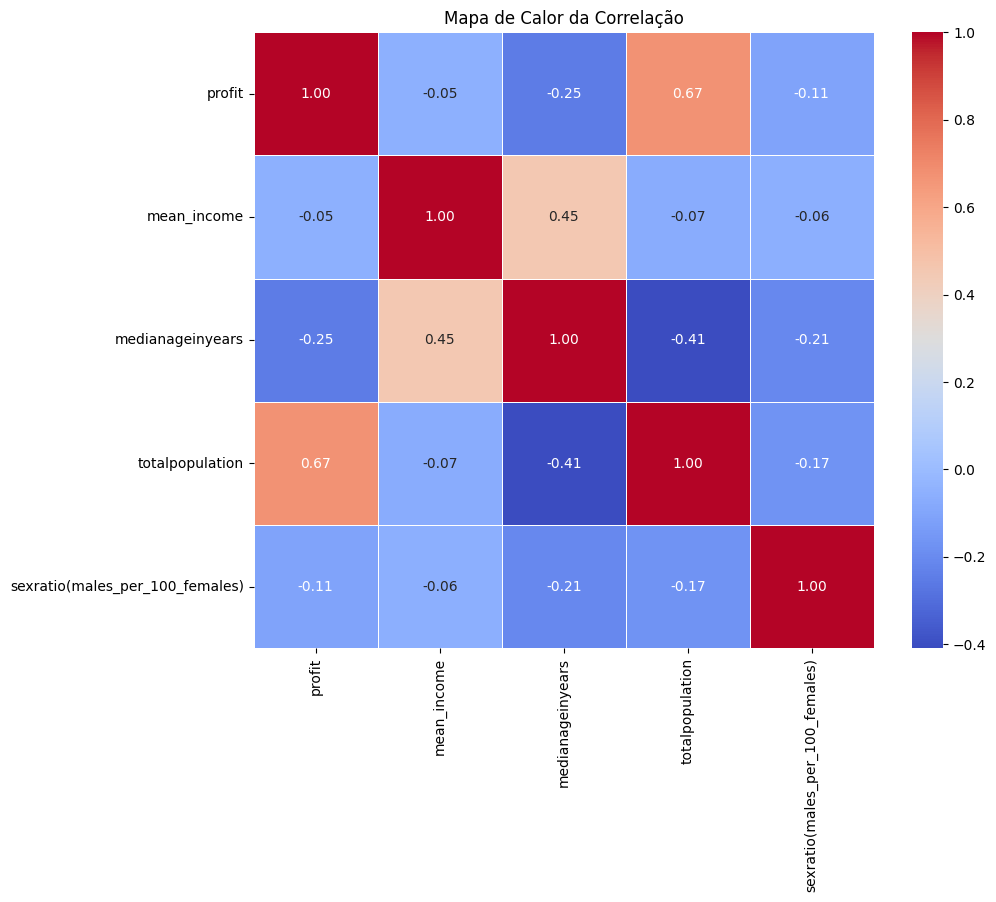

In [64]:

variaveis_selecionadas = df_geocode_silver[['profit', 'mean_income', 'medianageinyears','totalpopulation','sexratio(males_per_100_females)']]
matriz_correlacao1 = variaveis_selecionadas.corr()

# Crie um mapa de calor usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor da Correlação')
plt.show()


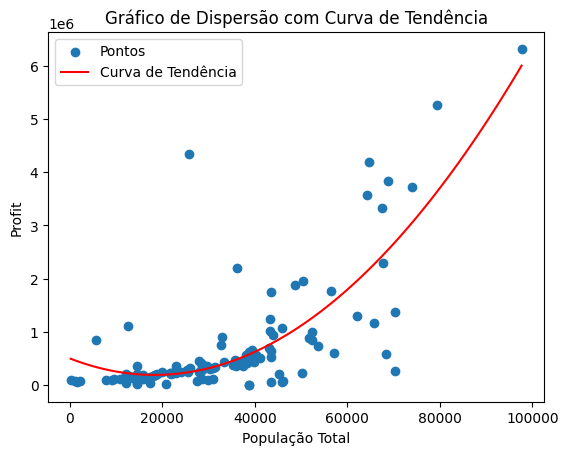

In [65]:

x = df_geocode_silver['totalpopulation']
y = df_geocode_silver['profit']

# Remover linhas com valores nulos ou infinitos
valid_entries = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x = x[valid_entries]
y = y[valid_entries]

# Ajustar um polinômio de grau 2 (curva quadrática)
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Criar um gráfico de dispersão
plt.scatter(x, y, label='Pontos')

# Gerar valores de x para a curva
x_curve = np.linspace(min(x), max(x), 100)
# Adicionar a curva de tendência
plt.plot(x_curve, polynomial(x_curve), color='red', label='Curva de Tendência')

# Configurar rótulos e título
plt.title('Gráfico de Dispersão com Curva de Tendência')
plt.xlabel('População Total')
plt.ylabel('Profit')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

Desse mapa de calor é possível inferir, com relação ao lucro, que:

Existe uma forte relação positiva entre o total da população e o lucro

É favoravél que o número de mulheres seja levemente superior ao número de homens

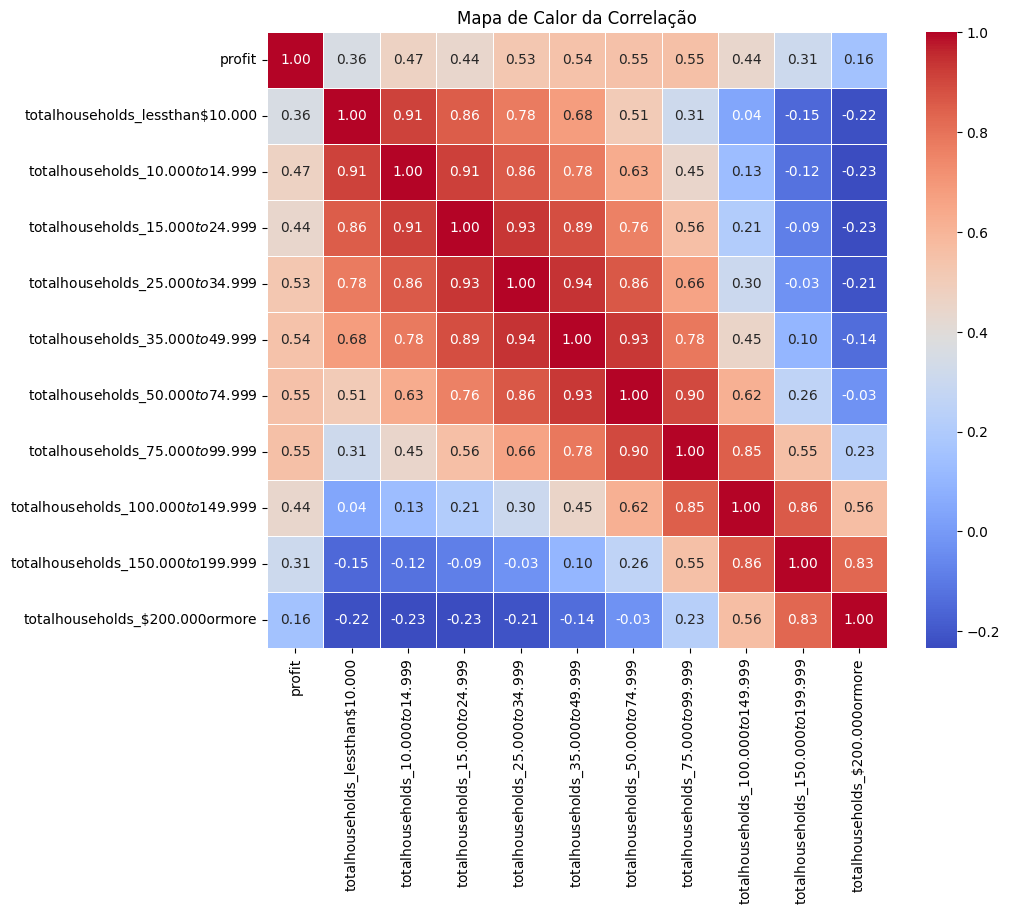

In [66]:
variaveis_selecionadas = df_geocode_silver[['profit', 'totalhouseholds_lessthan$10.000','totalhouseholds_$10.000to$14.999','totalhouseholds_$15.000to$24.999','totalhouseholds_$25.000to$34.999','totalhouseholds_$35.000to$49.999','totalhouseholds_$50.000to$74.999','totalhouseholds_$75.000to$99.999','totalhouseholds_$100.000to$149.999','totalhouseholds_$150.000to$199.999','totalhouseholds_$200.000ormore']]
matriz_correlacao2 = variaveis_selecionadas.corr()

# Crie um mapa de calor usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao2, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor da Correlação')
plt.show()

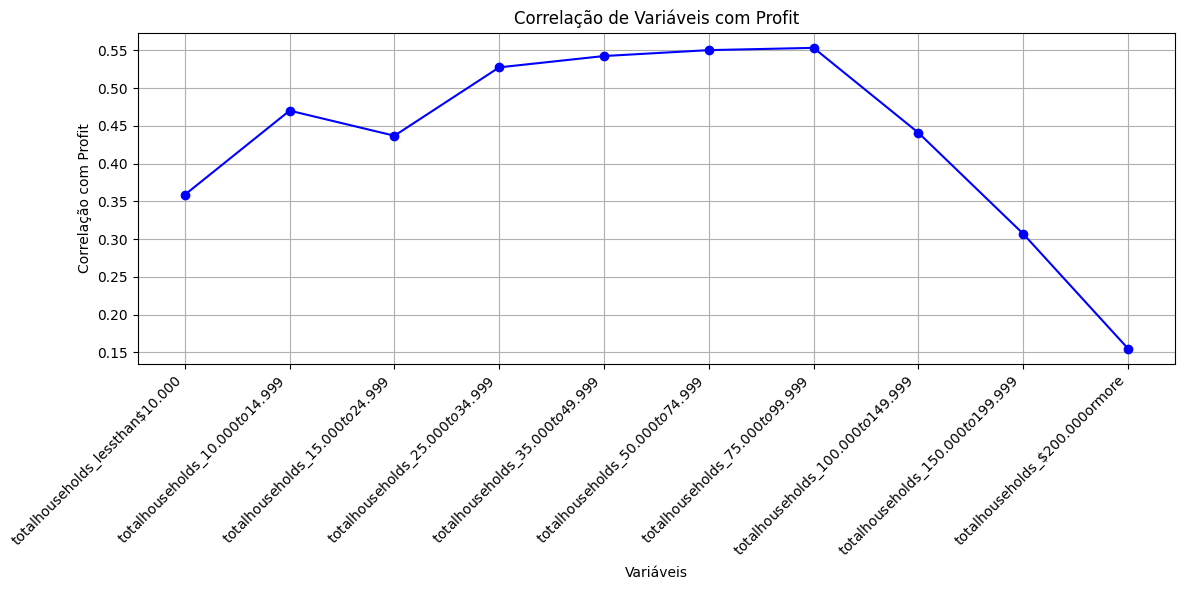

In [67]:


# Obtenha as correlações da primeira linha (exceto a correlação com 'profit' que é 1)
correlations = matriz_correlacao2.iloc[0, 1:]

# Obtenha o nome das variáveis
variables = correlations.index

# Crie um gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(variables, correlations, marker='o', linestyle='-', color='b')

# Adicione rótulos e título
plt.xlabel('Variáveis')
plt.ylabel('Correlação com Profit')
plt.title('Correlação de Variáveis com Profit')

# Adicione grade
plt.grid(True)

# Rotacione os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Exiba o gráfico
plt.tight_layout()
plt.show()


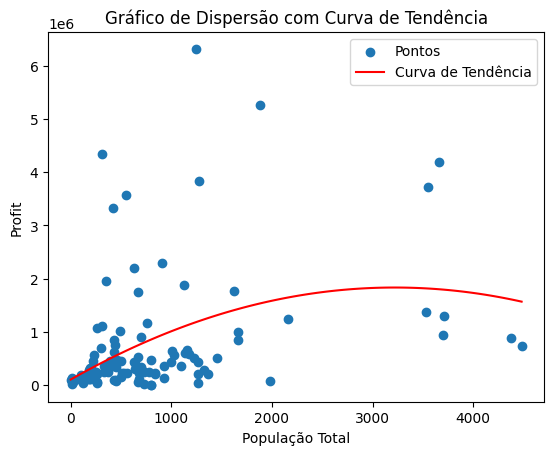

In [68]:

x = df_geocode_silver['totalhouseholds_lessthan$10.000']
y = df_geocode_silver['profit']

# Remover linhas com valores nulos ou infinitos
valid_entries = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x = x[valid_entries]
y = y[valid_entries]

# Ajustar um polinômio de grau 2 (curva quadrática)
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Criar um gráfico de dispersão
plt.scatter(x, y, label='Pontos')

# Gerar valores de x para a curva
x_curve = np.linspace(min(x), max(x), 100)
# Adicionar a curva de tendência
plt.plot(x_curve, polynomial(x_curve), color='red', label='Curva de Tendência')

# Configurar rótulos e título
plt.title('Gráfico de Dispersão com Curva de Tendência')
plt.xlabel('População Total')
plt.ylabel('Profit')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

Desses gráficos é possível ver que a renda ideal varia entre 25mil à 100mil

Parece que o melhor intervalo é entre 75mil à 100mil, mas o gráfico é praticamente estável nesse intervalo

Os piores intervalos parecem ser os acima de 150mil

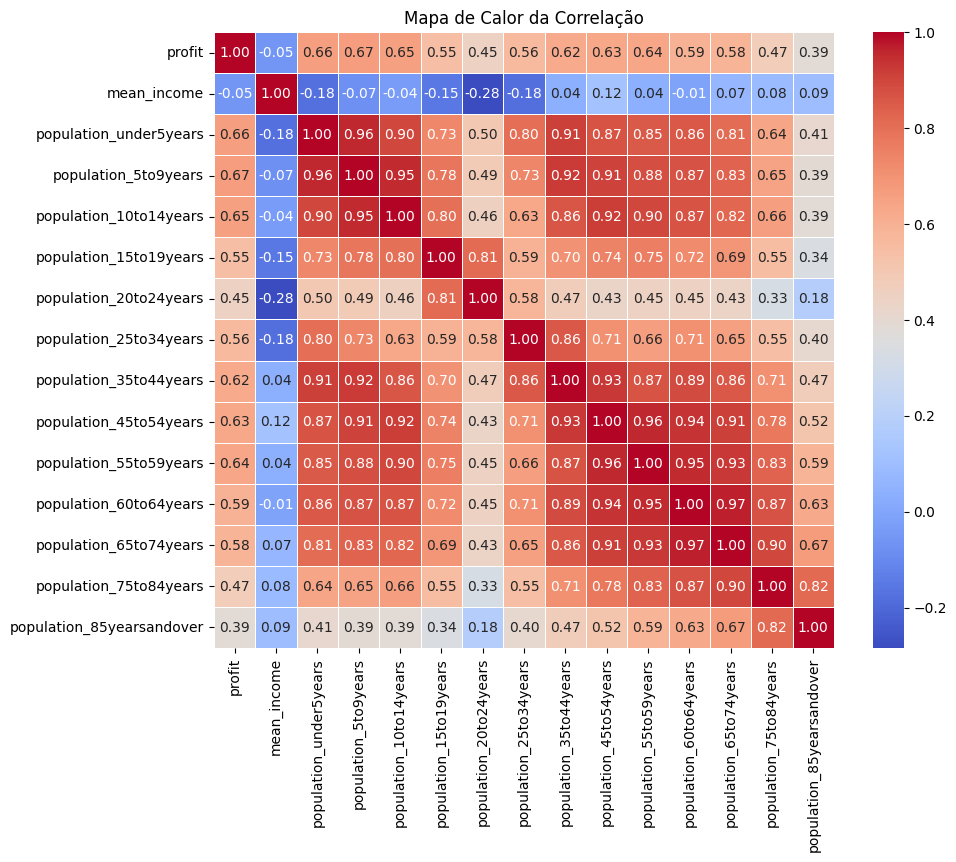

In [69]:
variaveis_selecionadas = df_geocode_silver[['profit', 'mean_income','population_under5years','population_5to9years','population_10to14years','population_15to19years','population_20to24years','population_25to34years','population_35to44years','population_45to54years','population_55to59years','population_60to64years','population_65to74years','population_75to84years','population_85yearsandover']]
matriz_correlacao3 = variaveis_selecionadas.corr()

# Crie um mapa de calor usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao3, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor da Correlação')
plt.show()

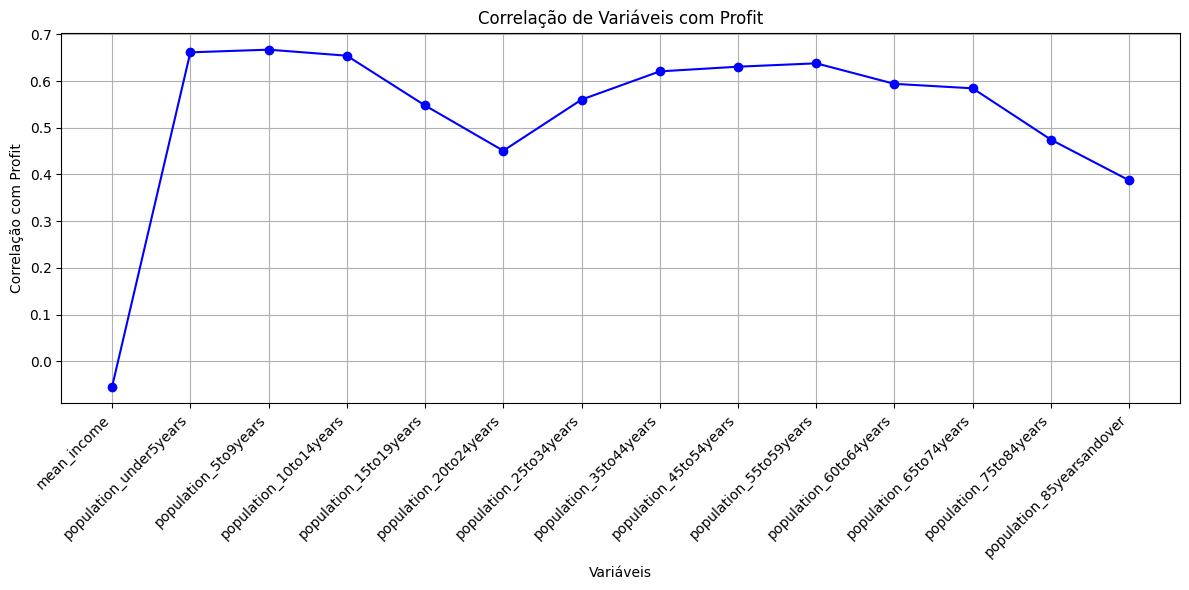

In [70]:

# Obtenha as correlações da primeira linha (exceto a correlação com 'profit' que é 1)
correlations = matriz_correlacao3.iloc[0, 1:]

# Obtenha o nome das variáveis
variables = correlations.index

# Crie um gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(variables, correlations, marker='o', linestyle='-', color='b')

# Adicione rótulos e título
plt.xlabel('Variáveis')
plt.ylabel('Correlação com Profit')
plt.title('Correlação de Variáveis com Profit')

# Adicione grade
plt.grid(True)

# Rotacione os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Exiba o gráfico
plt.tight_layout()
plt.show()


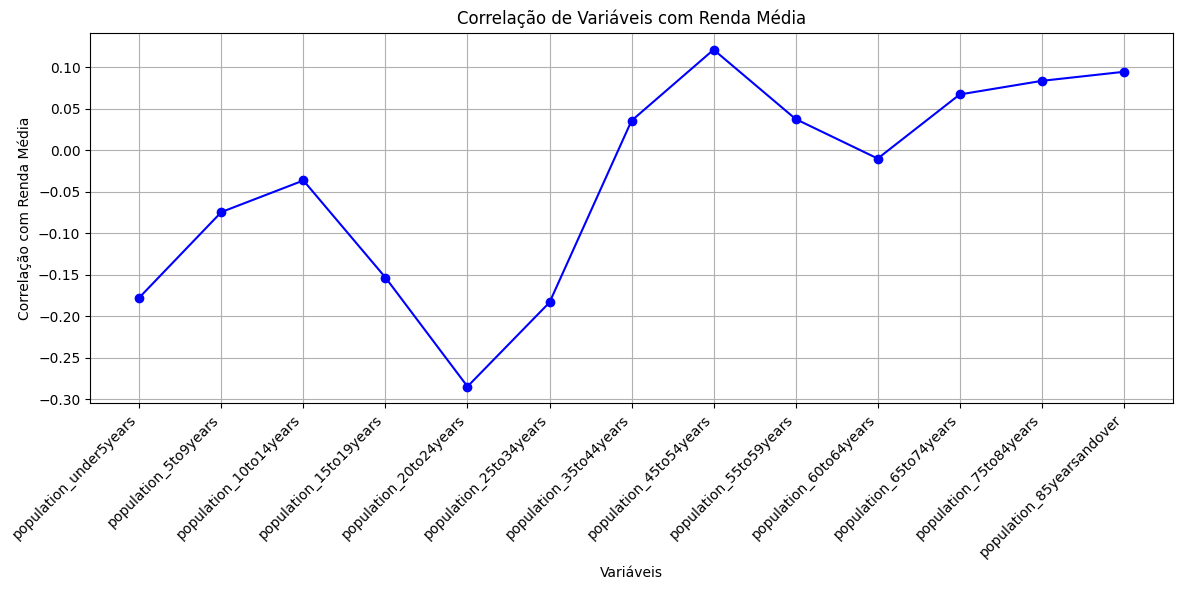

In [71]:
# Obtenha as correlações da primeira linha (exceto a correlação com 'profit' que é 1)
correlations = matriz_correlacao3.iloc[1, 2:]

# Obtenha o nome das variáveis
variables = correlations.index

# Crie um gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(variables, correlations, marker='o', linestyle='-', color='b')

# Adicione rótulos e título
plt.xlabel('Variáveis')
plt.ylabel('Correlação com Renda Média')
plt.title('Correlação de Variáveis com Renda Média')

# Adicione grade
plt.grid(True)

# Rotacione os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Exiba o gráfico
plt.tight_layout()
plt.show()

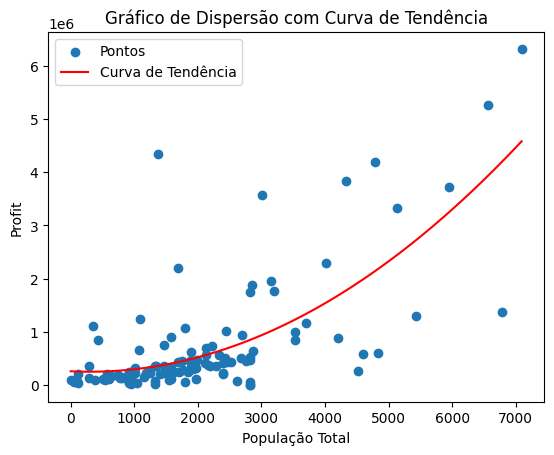

In [72]:

x = df_geocode_silver['population_under5years']
y = df_geocode_silver['profit']

# Remover linhas com valores nulos ou infinitos
valid_entries = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x = x[valid_entries]
y = y[valid_entries]

# Ajustar um polinômio de grau 2 (curva quadrática)
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Criar um gráfico de dispersão
plt.scatter(x, y, label='Pontos')

# Gerar valores de x para a curva
x_curve = np.linspace(min(x), max(x), 100)
# Adicionar a curva de tendência
plt.plot(x_curve, polynomial(x_curve), color='red', label='Curva de Tendência')

# Configurar rótulos e título
plt.title('Gráfico de Dispersão com Curva de Tendência')
plt.xlabel('População Total')
plt.ylabel('Profit')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

Dos gráficos relativos à demografia é possivel perceber que:

As faixas etárias que apresentaram melhores resultados para o lucro são as crianças até 14 anos 

E os adultos de 35 a 60 anos

Os piores resultados são encontrados para jovens adultos entre 15 e 35 anos e para idosos acima de 75 anos




Com isso tenho agora o público alvo:

Pessoas nas faixas hetárias de 0 a 14 anos e de 35 a 60 anos, possuindo renda familiar variando de 25mil à 100mil

Quanto maior a população melhor

O ideal é que a proporção de mulheres seja maior

Agora vou fazer 2 novos dataframes, um demográfico e um economico.

No demográfico eu vou ordenar em função do somatório da população nas faixas etárias alvo

No economico eu vou ordenar em função do somatório de familias com com renda entre 25mil e 100mil

Depois vou cruzar esses dois ranks, excluir os locais que possivelmente já possuem um laboratório e escolher os 3 melhores

In [73]:
df_candidatos_eco = df_economic
df_candidatos_demo = df_demo

In [74]:
df_candidatos_demo = df_demo

In [75]:
df_candidatos_eco.head()

,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,totalhouseholds_$100.000to$149.999,totalhouseholds_$150.000to$199.999,totalhouseholds_$200.000ormore,zip_code
0,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61,35004
1,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26,35005
2,ZCTA5 35006,71,20,117,104,154,176,124,194,51,7,35006
3,ZCTA5 35007,396,208,670,462,1173,1854,1578,2224,473,254,35007
4,ZCTA5 35010,700,610,1093,957,1056,1512,807,749,254,249,35010


In [76]:

df_candidatos_eco.drop('totalhouseholds_lessthan$10.000', axis=1, inplace=True)
df_candidatos_eco.drop('totalhouseholds_$10.000to$14.999', axis=1, inplace=True)
df_candidatos_eco.drop('totalhouseholds_$15.000to$24.999', axis=1, inplace=True)
df_candidatos_eco.drop('totalhouseholds_$100.000to$149.999', axis=1, inplace=True)
df_candidatos_eco.drop('totalhouseholds_$150.000to$199.999', axis=1, inplace=True)
df_candidatos_eco.drop('totalhouseholds_$200.000ormore', axis=1, inplace=True)

In [77]:
df_candidatos_eco.head()

,geographic_area_name,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,zip_code
0,ZCTA5 35004,513,647,1117,529,35004
1,ZCTA5 35005,293,353,562,299,35005
2,ZCTA5 35006,104,154,176,124,35006
3,ZCTA5 35007,462,1173,1854,1578,35007
4,ZCTA5 35010,957,1056,1512,807,35010


In [78]:
df_candidatos_eco['populacao_alvo'] = df_candidatos_eco[['totalhouseholds_$25.000to$34.999', 'totalhouseholds_$35.000to$49.999', 'totalhouseholds_$50.000to$74.999', 'totalhouseholds_$75.000to$99.999']].sum(axis=1)
df_candidatos_eco = df_candidatos_eco.sort_values('populacao_alvo', ascending=False)
df_candidatos_eco = df_candidatos_eco.drop_duplicates(subset='geographic_area_name')
df_candidatos_eco.head(30)


,geographic_area_name,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,zip_code,populacao_alvo
192333,ZCTA5 37013,3332,5433,8466,5507,37013,22738
492971,ZCTA5 79936,3597,5988,7624,4704,79936,21913
492018,ZCTA5 77449,2596,4315,7438,6491,77449,20840
458796,ZCTA5 77084,3349,4939,7049,5358,77084,20695
85347,ZCTA5 11226,3758,4492,6777,5290,11226,20317
236479,ZCTA5 32162,2323,4909,7107,5500,32162,19839
383234,ZCTA5 10467,4249,5519,6498,3263,10467,19529
159236,ZCTA5 37042,3908,4687,6378,3936,37042,18909
524318,ZCTA5 75287,2925,5943,6731,2806,75287,18405
350346,ZCTA5 11385,2752,3682,6058,5811,11385,18303


In [79]:
df_candidatos_eco_pronto = df_candidatos_eco

In [80]:
df_candidatos_demo.head()

,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_15to19years,population_20to24years,population_25to34years,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears,zip_code
0,ZCTA5 35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5,35004
1,ZCTA5 35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0,35005
2,ZCTA5 35006,2883,108.2,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2,35006
3,ZCTA5 35007,26332,95.0,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7,35007
4,ZCTA5 35010,20613,90.5,1306,1465,944,1217,1128,2513,2106,2950,1512,1472,2421,1155,424,42.6,35010


In [81]:
df_candidatos_demo.drop('population_15to19years', axis=1, inplace=True)
df_candidatos_demo.drop('population_20to24years', axis=1, inplace=True)
df_candidatos_demo.drop('population_25to34years', axis=1, inplace=True)
df_candidatos_demo.drop('population_60to64years', axis=1, inplace=True)
df_candidatos_demo.drop('population_65to74years', axis=1, inplace=True)
df_candidatos_demo.drop('population_75to84years', axis=1, inplace=True)
df_candidatos_demo.drop('population_85yearsandover', axis=1, inplace=True)

In [82]:
df_candidatos_demo['populacao_alvo'] = df_candidatos_demo[['population_under5years', 'population_5to9years', 'population_10to14years', 'population_35to44years','population_45to54years','population_55to59years']].sum(axis=1)
df_candidatos_demo = df_candidatos_demo.sort_values('populacao_alvo', ascending=False)
df_candidatos_demo = df_candidatos_demo.drop_duplicates(subset='geographicareaname')
df_candidatos_demo.head(30)

,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_35to44years,population_45to54years,population_55to59years,medianageinyears,zip_code,populacao_alvo
28375,ZCTA5 77494,118291,93.7,8929,11394,12285,23166,18058,5118,35.2,77494,78950
28338,ZCTA5 77449,128294,91.5,10192,11515,12289,21261,17449,6077,31.7,77449,78783
27375,ZCTA5 75034,108525,95.3,6533,8759,10586,18751,17630,5697,36.8,75034,67956
27400,ZCTA5 75070,104415,91.8,8029,8976,8850,19131,16093,5379,37.1,75070,66458
1885,ZCTA5 90011,111165,102.3,9263,10092,10008,15873,13603,4566,28.7,90011,63405
19135,ZCTA5 11368,112088,109.4,10107,8092,7766,18627,13408,5156,32.9,11368,63156
18364,ZCTA5 08701,102466,98.9,17564,14784,12176,9973,5772,2270,19.3,08701,62539
28236,ZCTA5 77084,107673,95.0,7892,7653,9496,16232,14125,5629,33.1,77084,61027
28324,ZCTA5 77433,90657,100.8,8062,8749,9384,16310,12113,4796,32.9,77433,59414
6960,ZCTA5 60629,110029,95.8,8901,7683,9135,14369,13048,5492,31.2,60629,58628


In [83]:
df_candidatos_demo_pronto = df_candidatos_demo


In [84]:
df_candidatos_demo_pronto = df_candidatos_demo_pronto.head(30)
df_candidatos_eco_pronto = df_candidatos_eco_pronto.head(30)

In [85]:
df_candidatos_demo_pronto

,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_35to44years,population_45to54years,population_55to59years,medianageinyears,zip_code,populacao_alvo
28375,ZCTA5 77494,118291,93.7,8929,11394,12285,23166,18058,5118,35.2,77494,78950
28338,ZCTA5 77449,128294,91.5,10192,11515,12289,21261,17449,6077,31.7,77449,78783
27375,ZCTA5 75034,108525,95.3,6533,8759,10586,18751,17630,5697,36.8,75034,67956
27400,ZCTA5 75070,104415,91.8,8029,8976,8850,19131,16093,5379,37.1,75070,66458
1885,ZCTA5 90011,111165,102.3,9263,10092,10008,15873,13603,4566,28.7,90011,63405
19135,ZCTA5 11368,112088,109.4,10107,8092,7766,18627,13408,5156,32.9,11368,63156
18364,ZCTA5 08701,102466,98.9,17564,14784,12176,9973,5772,2270,19.3,08701,62539
28236,ZCTA5 77084,107673,95.0,7892,7653,9496,16232,14125,5629,33.1,77084,61027
28324,ZCTA5 77433,90657,100.8,8062,8749,9384,16310,12113,4796,32.9,77433,59414
6960,ZCTA5 60629,110029,95.8,8901,7683,9135,14369,13048,5492,31.2,60629,58628


In [86]:
df_eco_demo = pd.merge(df_candidatos_demo_pronto, df_candidatos_eco_pronto, on='zip_code', how='inner')


In [87]:
df_eco_demo

,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_35to44years,population_45to54years,population_55to59years,medianageinyears,zip_code,populacao_alvo_x,geographic_area_name,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,populacao_alvo_y
0,ZCTA5 77449,128294,91.5,10192,11515,12289,21261,17449,6077,31.7,77449,78783,ZCTA5 77449,2596,4315,7438,6491,20840
1,ZCTA5 11368,112088,109.4,10107,8092,7766,18627,13408,5156,32.9,11368,63156,ZCTA5 11368,2901,4287,5514,4211,16913
2,ZCTA5 77084,107673,95.0,7892,7653,9496,16232,14125,5629,33.1,77084,61027,ZCTA5 77084,3349,4939,7049,5358,20695
3,ZCTA5 60629,110029,95.8,8901,7683,9135,14369,13048,5492,31.2,60629,58628,ZCTA5 60629,4130,5022,5651,2944,17747
4,ZCTA5 11385,107796,98.8,6994,6595,7054,16015,14852,6545,35.2,11385,58055,ZCTA5 11385,2752,3682,6058,5811,18303
5,ZCTA5 79936,111620,96.3,6549,7949,8723,13111,14345,7094,31.8,79936,57771,ZCTA5 79936,3597,5988,7624,4704,21913
6,ZCTA5 11208,101313,88.0,8811,7596,7326,12913,12625,6340,32.3,11208,55611,ZCTA5 11208,3247,4509,5032,3795,16583
7,ZCTA5 37013,97939,94.8,8566,7447,6855,14718,12157,5045,31.7,37013,54788,ZCTA5 37013,3332,5433,8466,5507,22738
8,ZCTA5 10467,101255,90.1,8204,6810,6969,13823,12710,5678,34.3,10467,54194,ZCTA5 10467,4249,5519,6498,3263,19529
9,ZCTA5 90250,97072,96.0,7766,7083,6310,13829,13360,5229,33.5,90250,53577,ZCTA5 90250,3063,4164,6678,3967,17872


In [88]:
merged_df = pd.merge(df_eco_demo, df_geocode_silver[['zip_code']], on='zip_code', how='left', indicator=True)

# Mantém apenas as linhas que não estão presentes em df_geocode_silver
df_final = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])


In [89]:
df_final

,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_35to44years,population_45to54years,population_55to59years,medianageinyears,zip_code,populacao_alvo_x,geographic_area_name,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,populacao_alvo_y
0,ZCTA5 77449,128294,91.5,10192,11515,12289,21261,17449,6077,31.7,77449,78783,ZCTA5 77449,2596,4315,7438,6491,20840
1,ZCTA5 11368,112088,109.4,10107,8092,7766,18627,13408,5156,32.9,11368,63156,ZCTA5 11368,2901,4287,5514,4211,16913
2,ZCTA5 77084,107673,95.0,7892,7653,9496,16232,14125,5629,33.1,77084,61027,ZCTA5 77084,3349,4939,7049,5358,20695
3,ZCTA5 60629,110029,95.8,8901,7683,9135,14369,13048,5492,31.2,60629,58628,ZCTA5 60629,4130,5022,5651,2944,17747
4,ZCTA5 11385,107796,98.8,6994,6595,7054,16015,14852,6545,35.2,11385,58055,ZCTA5 11385,2752,3682,6058,5811,18303
5,ZCTA5 79936,111620,96.3,6549,7949,8723,13111,14345,7094,31.8,79936,57771,ZCTA5 79936,3597,5988,7624,4704,21913
6,ZCTA5 11208,101313,88.0,8811,7596,7326,12913,12625,6340,32.3,11208,55611,ZCTA5 11208,3247,4509,5032,3795,16583
7,ZCTA5 37013,97939,94.8,8566,7447,6855,14718,12157,5045,31.7,37013,54788,ZCTA5 37013,3332,5433,8466,5507,22738
8,ZCTA5 10467,101255,90.1,8204,6810,6969,13823,12710,5678,34.3,10467,54194,ZCTA5 10467,4249,5519,6498,3263,19529
9,ZCTA5 90250,97072,96.0,7766,7083,6310,13829,13360,5229,33.5,90250,53577,ZCTA5 90250,3063,4164,6678,3967,17872


o df_final está apenas com 10 entradas, posso utilizar a populaçõa como um critério de desempate, mas quero olhar o mapa e ver onde estão esses 10 pontos

In [90]:
print(df_final)

  geographicareaname  totalpopulation  sexratio(males_per_100_females)  \
0        ZCTA5 77449           128294                             91.5   
1        ZCTA5 11368           112088                            109.4   
2        ZCTA5 77084           107673                             95.0   
3        ZCTA5 60629           110029                             95.8   
4        ZCTA5 11385           107796                             98.8   
5        ZCTA5 79936           111620                             96.3   
6        ZCTA5 11208           101313                             88.0   
7        ZCTA5 37013            97939                             94.8   
8        ZCTA5 10467           101255                             90.1   
9        ZCTA5 90250            97072                             96.0   

   population_under5years  population_5to9years  population_10to14years  \
0                   10192                 11515                   12289   
1                   10107          

In [91]:


# Supondo que 'lab_id' seja uma coluna que identifica exclusivamente as franquias
df_geocode_silver['franchise_status'] = 'existing'
df_final['franchise_status'] = 'candidate'

# Adicionando a coluna 'marker_color' com base no status da franquia
df_geocode_silver['marker_color'] = 'red'
df_final['marker_color'] = 'blue'

# Convertendo as coordenadas para números nas franquias existentes
df_geocode_silver[['latitude', 'longitude']] = df_geocode_silver['location'].str.split(',', expand=True).astype(float)

# Geocodificando os códigos postais das franquias candidatas
geolocator = Nominatim(user_agent="geo_locator")

for i, row in df_final.iterrows():
    location = geolocator.geocode(row['zip_code'])
    if location:
        df_final.at[i, 'latitude'] = location.latitude
        df_final.at[i, 'longitude'] = location.longitude

# Concatenar os DataFrames das franquias existentes com as coordenadas das candidatas
df_geocode_combined = pd.concat([df_geocode_silver[['franchise_status', 'marker_color', 'latitude', 'longitude', 'zip_code']],
                                 df_final[['franchise_status', 'marker_color', 'latitude', 'longitude','zip_code']]],
                                ignore_index=True)

# Criando um mapa centrado nas coordenadas médias
map_center = [df_geocode_combined['latitude'].mean(), df_geocode_combined['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=4)

# Adicionando marcadores ao mapa
# Adicionando marcadores ao mapa
for i, row in df_geocode_combined.iterrows():
    location = (row['latitude'], row['longitude'])
    
    popup_text = f"{row['zip_code']}"
    if 'lab_id' in row:
        popup_text += f" - {row['lab_id']} - {row.get('address', '')}"

    folium.Marker(
        location=location,
        popup=popup_text,
        icon=folium.Icon(color=row['marker_color'])
    ).add_to(mymap)

# Exibindo o mapa
mymap




In [92]:
df_geocode_combined.tail(10)

,franchise_status,marker_color,latitude,longitude,zip_code
118,candidate,blue,29.819325,-95.739747,77449
119,candidate,blue,40.748091,-73.860623,11368
120,candidate,blue,18.520651,-88.320808,77084
121,candidate,blue,41.781218,-87.712077,60629
122,candidate,blue,40.703901,-73.892517,11385
123,candidate,blue,31.752732,-106.297424,79936
124,candidate,blue,40.676286,-73.874658,11208
125,candidate,blue,36.061917,-86.650487,37013
126,candidate,blue,37.663210,126.845118,10467
127,candidate,blue,48.152874,22.629366,90250


In [93]:
# 77084

df_geocode_combined.at[120, 'latitude'] = 29.82698
df_geocode_combined.at[120, 'longitude'] = -95.6612

In [94]:
# 11368

df_geocode_combined.at[119, 'latitude'] = 40.74962
df_geocode_combined.at[119, 'longitude'] = -73.85264

In [95]:
# 37013

df_geocode_combined.at[125, 'latitude'] = 36.04658
df_geocode_combined.at[125, 'longitude'] = -86.63445

In [96]:
# 90250

df_geocode_combined.at[127, 'latitude'] = 33.91383
df_geocode_combined.at[127, 'longitude'] = -118.34996

In [97]:
# 10467

df_geocode_combined.at[126, 'latitude'] = 40.87522
df_geocode_combined.at[126, 'longitude'] = -73.872

In [98]:
for i, row in df_final.iterrows():
    # Verificar se a geocodificação já foi feita (latitude e longitude não são NaN)
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        # Se não for a primeira rodada, use as coordenadas adicionadas manualmente
        df_final.at[i, 'latitude'] = row['latitude']
        df_final.at[i, 'longitude'] = row['longitude']

# ...

# Criando um mapa centrado nas coordenadas médias
map_center = [df_geocode_combined['latitude'].mean(), df_geocode_combined['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=4)

# Adicionando marcadores ao mapa
for i, row in df_geocode_combined.iterrows():
    location = (row['latitude'], row['longitude'])
    
    popup_text = f"{row['zip_code']}"
    if 'lab_id' in row:
        popup_text += f" - {row['lab_id']} - {row.get('address', '')}"

    folium.Marker(
        location=location,
        popup=popup_text,
        icon=folium.Icon(color=row['marker_color'])
    ).add_to(mymap)

# Exibindo o mapa
mymap

In [99]:
df_final

,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_35to44years,population_45to54years,population_55to59years,medianageinyears,...,geographic_area_name,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,populacao_alvo_y,franchise_status,marker_color,latitude,longitude
0,ZCTA5 77449,128294,91.5,10192,11515,12289,21261,17449,6077,31.7,...,ZCTA5 77449,2596,4315,7438,6491,20840,candidate,blue,29.819325,-95.739747
1,ZCTA5 11368,112088,109.4,10107,8092,7766,18627,13408,5156,32.9,...,ZCTA5 11368,2901,4287,5514,4211,16913,candidate,blue,40.748091,-73.860623
2,ZCTA5 77084,107673,95.0,7892,7653,9496,16232,14125,5629,33.1,...,ZCTA5 77084,3349,4939,7049,5358,20695,candidate,blue,18.520651,-88.320808
3,ZCTA5 60629,110029,95.8,8901,7683,9135,14369,13048,5492,31.2,...,ZCTA5 60629,4130,5022,5651,2944,17747,candidate,blue,41.781218,-87.712077
4,ZCTA5 11385,107796,98.8,6994,6595,7054,16015,14852,6545,35.2,...,ZCTA5 11385,2752,3682,6058,5811,18303,candidate,blue,40.703901,-73.892517
5,ZCTA5 79936,111620,96.3,6549,7949,8723,13111,14345,7094,31.8,...,ZCTA5 79936,3597,5988,7624,4704,21913,candidate,blue,31.752732,-106.297424
6,ZCTA5 11208,101313,88.0,8811,7596,7326,12913,12625,6340,32.3,...,ZCTA5 11208,3247,4509,5032,3795,16583,candidate,blue,40.676286,-73.874658
7,ZCTA5 37013,97939,94.8,8566,7447,6855,14718,12157,5045,31.7,...,ZCTA5 37013,3332,5433,8466,5507,22738,candidate,blue,36.061917,-86.650487
8,ZCTA5 10467,101255,90.1,8204,6810,6969,13823,12710,5678,34.3,...,ZCTA5 10467,4249,5519,6498,3263,19529,candidate,blue,37.663210,126.845118
9,ZCTA5 90250,97072,96.0,7766,7083,6310,13829,13360,5229,33.5,...,ZCTA5 90250,3063,4164,6678,3967,17872,candidate,blue,48.152874,22.629366


No mapa acima é possível observar em vermelho os locais onde já existem unidades do laboratório

Em azul estão os 10 melhores candidatos de acordo com os critérios de população e economicos

A cidade de Houston no Texas apresentou 2 pontos muito próximos um do outro, oque provavelmente significa que, escolhendo um endereço correto proximo da divisa desses dois zipcodes

é possível que se venda testes de laboratório para ambos as populações.

O zipcode 77449 aprensentou os melhores dados para a demografia e renda familiar alvo dentre os 10 candidatos, e vai ser 1 das minhas escolhas

A cidade de Nova york apresentou 4 pontos, vou escolher 1 deles.

A primeira vista 11368	apresenta os melhores números para a cidade, 

mas olhando o mapa da para ver que ele está mais afastado dos outros candidatos além disso a proporção de homens para mulheres está ruim

Como visto pelo mapa de calor 1, é melhor ter uma proporção com mais mulheres do que homens

Já o ponto 11385 apresenta os 2 melhores números para a cidade de NY e fica relativamente próximo dos pontos 11368 e 11208

Oque novamente significa que ao escolher o zipcode 11385, é possível atrair a população desses zipcodes vizinhos

Para a cidade de NY minha escolha é 11385



In [100]:

df_final = df_final.drop([0, 1, 2, 4, 6, 8])

In [101]:
print(df_final[['geographicareaname', 'totalpopulation', 'populacao_alvo_y', 'populacao_alvo_x']])


  geographicareaname  totalpopulation  populacao_alvo_y  populacao_alvo_x
3        ZCTA5 60629           110029             17747             58628
5        ZCTA5 79936           111620             21913             57771
7        ZCTA5 37013            97939             22738             54788
9        ZCTA5 90250            97072             17872             53577


Por fim analisando os ultimos 4 zipcodes:
60629 apresenta a maior população dentre as 4, tendo também o maior número de pessoas dentro da faixa etária desejada(representado por populacao_alvo_x)
Porém, aprensentou o pior número entre os 4 de familias dentro da faixa de renda alvo (representado por populacao_alvo_y)

90250 apresenta números ruins tanto de população, renda familiar e de população dentro da faixa etária

Por fim, sobraram 79936 e 37013 que apresentaram números sólidos tanto de renda familiar e faixa etária adequadas
Minha escolha final será 79936 por aprensetar maior população total, o fator que apresentou maior correlação com a varivél lucro


Com isso minhas escolhas foram:

77449 - Houston - TEXAS

11385 - New York - NEW YORK

79936 - El Paso - TEXAS


In [102]:
df_geocode_combined

,franchise_status,marker_color,latitude,longitude,zip_code
0,existing,red,34.000319,-84.162972,30096
1,existing,red,43.231133,-75.444536,13440
2,existing,red,47.716279,-122.183815,98034
3,existing,red,33.909388,-84.352910,30342
4,existing,red,40.930993,-90.943760,61469
...,...,...,...,...,...
123,candidate,blue,31.752732,-106.297424,79936
124,candidate,blue,40.676286,-73.874658,11208
125,candidate,blue,36.046580,-86.634450,37013
126,candidate,blue,40.875220,-73.872000,10467


In [103]:
zip_codes_to_change = ['77449', '11385', '79936']
new_marker_color = 'green'

# Alterando os valores
df_geocode_combined.loc[df_geocode_combined['zip_code'].isin(zip_codes_to_change), 'marker_color'] = new_marker_color


In [104]:

df_geocode_combined = df_geocode_combined[df_geocode_combined['marker_color'] = 'green']


In [105]:
for i, row in df_geocode_combined.iterrows():
    # Verificar se a geocodificação já foi feita (latitude e longitude não são NaN)
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        # Se não for a primeira rodada, use as coordenadas adicionadas manualmente
        df_geocode_combined.at[i, 'latitude'] = row['latitude']
        df_geocode_combined.at[i, 'longitude'] = row['longitude']

# ...

# Criando um mapa centrado nas coordenadas médias
map_center = [df_geocode_combined['latitude'].mean(), df_geocode_combined['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=4)

# Adicionando marcadores ao mapa
for i, row in df_geocode_combined.iterrows():
    location = (row['latitude'], row['longitude'])
    
    popup_text = f"{row['zip_code']}"
    if 'lab_id' in row:
        popup_text += f" - {row['lab_id']} - {row.get('address', '')}"

    folium.Marker(
        location=location,
        popup=popup_text,
        icon=folium.Icon(color=row['marker_color'])
    ).add_to(mymap)

# Exibindo o mapa
mymap